<a href="https://colab.research.google.com/github/Jaesu26/dacon-point-of-interest-category-classification/blob/main/2022-10-06-%EA%B4%80%EA%B4%91%EC%A7%80%EC%A0%90%EC%A0%95%EB%B3%B4-%EC%B9%B4%ED%85%8C%EA%B3%A0%EB%A6%AC-%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2022 관광데이터 AI 경진대회

In [1]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [2]:
# !pip install albumentations==1.2.1
# !pip install adabelief-pytorch
# !pip install timm
# !pip install ttach

In [3]:
!pip install transformers==4.8.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 14.9 MB/s 
     |████████████████████████████████| 880 kB 51.0 MB/s 
     |████████████████████████████████| 3.3 MB 41.4 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=1dcc492151f4b9de56e91748baf536b4d03b7ae8ee2d05878d061b065f77b95a
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


`-` 런타임 재시작

## 데이터 불러오기

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import random
import copy
import re
import os
import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score

from typing import Any, Callable, Dict, List, Optional, Sequence, Tuple, Union
from numpy.typing import NDArray

from tqdm.auto import tqdm
from glob import glob

warnings.filterwarnings('ignore')

In [5]:
from google.colab import drive

drive.mount('/content/drive')  ## 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [6]:
%cd  '/content/drive/MyDrive/Colab Notebooks/관광지점정보-카테고리-분류/Data'

/content/drive/MyDrive/Colab Notebooks/관광지점정보-카테고리-분류/Data


In [7]:
# !unzip -qq '/content/drive/MyDrive/Colab Notebooks/관광지점정보-카테고리-분류/Data/open.zip'

- 데이터 불러오기

In [8]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv') 

In [9]:
target = df['cat3'].values  ## 최종적으로 예측해야할 카테고리

`-` target 라벨 인코딩

In [10]:
le = LabelEncoder()
target = le.fit_transform(target)

- 하이퍼파라미터 (텍스트)

In [11]:
MODEL_NAME = {'electra':'kykim/electra-kor-base', 
              'bert':'kykim/bert-kor-base',
              'funnel':'kykim/funnel-kor-base', 
              'koelectra':'monologg/koelectra-base-v3-discriminator',
              'kcelectra':'beomi/KcELECTRA-base',}

MODEL_TYPE = 'electra'
MODEL_DEFAULT_WEIGHT_PATH = f'{MODEL_TYPE}_default_weight.pt' 
SAVE_PATH = './weight2'
NUM_CLASSES = len(np.unique(target))  ## 128개
NUM_FOLDS = 5
NUM_EPOCHS = 30
MAX_LEN = 200
BATCH_SIZE = 64
LEARNING_RATE = 5e-5
LABEL_SMOOTHING = 0.1  ## 잘못 라벨링된 데이터가 존재
SEED = 2022

- 가중치 저장폴더

In [12]:
def create_folder(path: str) -> None:
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError as error:
        print(error)

In [13]:
create_folder(SAVE_PATH)

## 시각화

In [ ]:
plt.rc('font', family='NanumBarunGothic') 

### 라벨

In [ ]:
df.groupby(['cat1', 'cat2']).agg({'cat3':[np.unique, lambda x: len(np.unique(x)), len]})

cat3  \
                                                                unique   
cat1         cat2                                                        
레포츠          레포츠소개                                               수상레포츠   
             복합 레포츠                                             복합 레포츠   
             수상 레포츠  [래프팅, 민물낚시, 바다낚시, 수영, 스노쿨링/스킨스쿠버다이빙, 요트, 윈드서핑/...   
             육상 레포츠  [ATV, MTB, 골프, 번지점프, 빙벽등반, 사격장, 수련시설, 스케이트, 스키...   
             항공 레포츠                             [스카이다이빙, 헹글라이딩/패러글라이딩]   
쇼핑           쇼핑             [5일장, 공예,공방, 면세점, 백화점, 상설시장, 전문상가, 특산물판매점]   
숙박           숙박시설    [게스트하우스, 모텔, 민박, 서비스드레지던스, 유스호스텔, 콘도미니엄, 펜션, 한...   
음식           음식점           [바/까페, 서양식, 일식, 중식, 채식전문점, 클럽, 패밀리레스토랑, 한식]   
인문(문화/예술/역사) 건축/조형물             [기념탑/기념비/전망대, 다리/대교, 동상, 분수, 유명건물, 터널]   
             공연/행사      [기타행사, 대중콘서트, 뮤지컬, 박람회, 연극, 전통공연, 컨벤션, 클래식음악회]   
             문화시설    [공연장, 기념관, 대형서점, 도서관, 문화원, 문화전수시설, 미술관/화랑, 박물관...   
             산업관광지                                      [기타, 발전소, 식음료]   
             역사관광지   [고궁, 고택, 문, 민속마을, 사찰, 생가, 성, 안보관광, 유적지/사적지, 종교성지]   
             체험관광지                             [농.산.어촌 체험, 이색거리, 이색체험]   
             축제                                         [문화관광축제, 일반축제]   
             휴양관광지   [공원, 관광단지, 온천/욕장/스파, 유람선/잠수함관광, 유원지, 이색찜질방, 테마...   
자연           관광자원                                       [기암괴석, 희귀동.식물]   
             자연관광지   [강, 계곡, 국립공원, 군립공원, 도립공원, 동굴, 등대, 산, 섬, 수목원, 약...   

                                      
                    <lambda_0>   len  
cat1         cat2                     
레포츠          레포츠소개           1    11  
             복합 레포츠          1    24  
             수상 레포츠          8   277  
             육상 레포츠         19  2288  
             항공 레포츠          2    11  
쇼핑           쇼핑              7   696  
숙박           숙박시설            9  1434  
음식           음식점             8  4912  
인문(문화/예술/역사) 건축/조형물          6   328  
             공연/행사           8   139  
             문화시설           13  1220  
             산업관광지           3    93  
             역사관광지          10  1571  
             체험관광지           3   805  
             축제              2   569  
             휴양관광지           8   889  
자연           관광자원            2   141  
             자연관광지          18  1578

`-` 라벨 불균형이 매우 심하다

`-` 항공 레포츠는 범주 2개에 총 11개의 데이터가 있는 반면, 음식점은 범주 8개에 총 4912개의 데이터가 있다

`-` 하지만 평가산식은 `weighted f1 score`이므로 적은 클래스의 카테고리는 내다 버려도 좋은 점수를 얻을 수 있다

`-` 그런데 train과 test의 분포가 다르다면?......

`-` 무작위로 샘플링했다면 둘의 분포가 비슷할 것이다

- 카테고리 3

In [ ]:
df['cat3'].value_counts().describe()

count     128.000000
mean      132.703125
std       349.099299
min         2.000000
25%        11.000000
50%        36.000000
75%       121.500000
max      3438.000000
Name: cat3, dtype: float64

`-` 데이터가 2개 뿐인 범주가 존재한다

`-` 3438개로 가장 많은 데이터를 가진 범주는 한식이다

`-` 한식 카테고리를 잘 맞춰야 좋은 점수를 받을 수 있다

`-` 적은 데이터를 가진 범주를 드랍하는 것도 고려해보자

In [ ]:
df['cat3'].value_counts().to_dict()

{'한식': 3438,
 '야영장,오토캠핑장': 1558,
 '바/까페': 785,
 '유적지/사적지': 622,
 '일반축제': 549,
 '사찰': 495,
 '이색거리': 467,
 '펜션': 445,
 '한옥스테이': 404,
 '모텔': 340,
 '농.산.어촌 체험': 332,
 '박물관': 310,
 '공원': 271,
 '상설시장': 270,
 '트래킹': 246,
 '전시관': 243,
 '산': 239,
 '서양식': 226,
 '유원지': 211,
 '중식': 209,
 '자연생태관광지': 207,
 '해수욕장': 207,
 '미술관/화랑': 204,
 '골프': 179,
 '전문상가': 173,
 '테마공원': 172,
 '5일장': 165,
 '계곡': 160,
 '일식': 151,
 '기념탑/기념비/전망대': 148,
 '항구/포구': 134,
 '관광단지': 126,
 '공연장': 120,
 '민물낚시': 119,
 '자연휴양림': 118,
 '문화원': 113,
 '섬': 111,
 '유명건물': 105,
 '강': 104,
 '수목원': 95,
 '수련시설': 95,
 '도서관': 92,
 '고택': 92,
 '희귀동.식물': 88,
 '성': 85,
 '게스트하우스': 83,
 '기타': 79,
 '민속마을': 76,
 '기타행사': 71,
 '종교성지': 65,
 '기념관': 64,
 '패밀리레스토랑': 61,
 '스키(보드) 렌탈샵': 60,
 '바다낚시': 57,
 '홈스테이': 57,
 '기암괴석': 53,
 '온천/욕장/스파': 53,
 '생가': 43,
 '다리/대교': 41,
 '공예,공방': 41,
 '폭포': 40,
 '민박': 39,
 '특산물판매점': 37,
 '채식전문점': 36,
 '고궁': 36,
 '자동차경주': 35,
 '콘도미니엄': 34,
 '안보관광': 34,
 '호수': 30,
 '유람선/잠수함관광': 30,
 '박람회': 29,
 '수영': 27,
 '윈드서핑/제트스키': 27,
 '썰매장'

### 텍스트

In [ ]:
df['overview'].str.len().describe()

count    16986.000000
mean       334.291711
std        283.720345
min          7.000000
25%        168.250000
50%        274.000000
75%        415.000000
max       7972.000000
Name: overview, dtype: float64

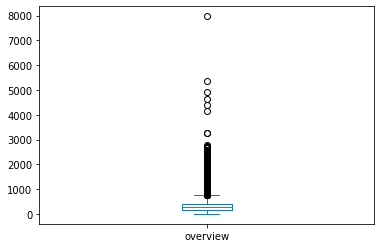

In [ ]:
df['overview'].str.len().plot.box()

## 텍스트 전처리 함수

`-` 텍스트 전처리 part에서 사용할 함수를 구현해놓음

`-` 텍스트 전처리 part를 먼저 읽어봐야 함

- 텍스트

`-` 한글만 봐도 관광지점 카테고리를 구분할 수 있을 것 같다

In [14]:
## 해당 단어의 유무가 라벨에 영향을 준다면 채택하자
minor2major_dict = {#'tv':'티비',
                    #'kbs':'방송',
                    #'sbs':'방송',
                    #'mbc':'방송'
                    #'dmz':'비무장지대', 
                    'bbq':'바베큐',
                    '바비큐':'바베큐',  
                    #'led':'조명',
                    #'sns':'소셜',
                    'art':'미술',
                    #'ktx':'기차',
                    'vr':'가상현실',
                    'vrzone':'가상현실',
                    'museum':'박물관',
                    '뮤지엄':'박물관',
                    #'atv':'오토바이',
                    'cafe':'카페',
                    '까페':'카페',
                    '5일장':'오일장',
                    #'dvd':'디비디',
                    'dj':'디제이',
                    'edm':'댄스 뮤직',
                    'gallery':'갤러리',
                    'steak':'스테이크',
                    'golf':'골프',
                    'festival':'페스티벌',
                    'motel':'모텔',
                    'hotel':'호텔',
                    'shopping':'쇼핑',
                    'camp':'캠프',
                    '트래킹':'트레킹',
                    '무언극':'연극',
                    'coffee':'커피',   
                    'bungee':'번지',
                    'cinema':'영화관',
                    'bread':'빵',
                    'atv':'오토바이',       
                    'mtb':'산악자전거',       
                    }

In [15]:
## 토큰화가 제대로 이루어지도록 다시 교체
major2minor_dict = {'디비디':'dvd',
                    '디제이':'dj',
                    '모텔':'motel',
                    }

In [16]:
def clean_texts(texts: Sequence[str]) -> List[str]: 
    new_texts = [] 
    for text in texts: 
        text = text.lower()
        text = re.sub(r'\w*\d\w*', '', text)  ## 숫자를 포함한 단어 제거
        text = re.sub(r'[^\uAC00-\uD7A3\s\.]', ' ', text)  ## 한글 음절, 띄어쓰기, 마침표 제외하고 모두 삭제
        text = re.sub(r'\s+', ' ', text)  ## extra space 제거
        text = text.strip()   
        new_texts.append(text) 
    return new_texts

In [17]:
def minor2major(texts: Sequence[str], minor2major_dict: Dict[str, str]) -> List[str]:
    new_texts = []
    for text in texts:
        for minor, major in minor2major_dict.items():
            text = text.replace(minor, major)
        new_texts.append(text)
    return new_texts

In [18]:
def major2minor(texts: Sequence[str], major2minor_dict: Dict[str, str]) -> List[str]:
    new_texts = []
    for text in texts:
        for major, minor in major2minor_dict.items():
            text = text.replace(major, minor)
        new_texts.append(text)
    return new_texts

In [19]:
def cut_texts(texts: Sequence[str], max_len: int = 550) -> List[str]:
    new_texts = []
    for text in texts:
        end_idx = len(text)
        full_stop_idx = [idx for idx, char in enumerate(text) if char == '.']
        if full_stop_idx:
            full_stop_idx = np.array(full_stop_idx)
            end_idxes = full_stop_idx[full_stop_idx < max_len].tolist()
            if end_idxes:
                end_idx = end_idxes[-1]
            else:
                end_idx = full_stop_idx[0]

        new_texts.append(text[:end_idx].strip())
    return new_texts

In [20]:
def delete_duplicate_fullstops(texts: Sequence[str]) -> List[str]:
    new_texts = []
    for text in texts:
        text = re.sub(r'\.+', '.', text)  ## 중복 마침표 제거 (word1~...~word2 -> word1~.~word2)
        new_texts.append(text)
    return new_texts

In [21]:
def delete_fullstops(texts: Sequence[str]) -> List[str]:
    new_texts = []
    for text in texts:
        text = re.sub(r'\.', ' ', text)   ## 마침표 제거 (word1~.~word2 -> word1~ ~word2)
        text = re.sub(r'\s+', ' ', text)  ## extra space 제거 (word1~~word2 -> word1~word2)
        text = text.strip()     
        new_texts.append(text)
    return new_texts

In [22]:
def add_fullstop(texts: Sequence[str]) -> List[str]:
    new_texts = []
    for text in texts:
        if not text.endswith('.'):
            text = ''.join([text, '.'])
        new_texts.append(text)
    return new_texts

### 텍스트 길이와 토큰 길이

In [ ]:
import torch
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME[MODEL_TYPE])  

Downloading:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/620 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/344k [00:00<?, ?B/s]

### cut text 적용 X

In [ ]:
train_texts = df['overview'].values
train_texts = minor2major(train_texts, minor2major_dict)
train_texts = clean_texts(train_texts)
train_texts = major2minor(train_texts, major2minor_dict)
# train_texts = cut_texts(train_texts)
train_texts = delete_duplicate_fullstops(train_texts)

- 텍스트 길이

In [ ]:
texts_len = list(map(len, train_texts))

25%:  154.0
50%:  253.0
75%:  378.0
85%:  467.0
90%:  549.5
95%:  712.0
99%:  1237.1500000000015


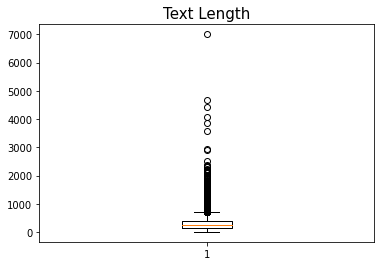

In [ ]:
plt.boxplot(texts_len)
print('25%: ', np.quantile(texts_len, q=0.25))
print('50%: ', np.quantile(texts_len, q=0.5))
print('75%: ', np.quantile(texts_len, q=0.75))
print('85%: ', np.quantile(texts_len, q=0.85))
print('90%: ', np.quantile(texts_len, q=0.9))
print('95%: ', np.quantile(texts_len, q=0.95))
print('99%: ', np.quantile(texts_len, q=0.99))
plt.title('Text Length', fontsize=15)
plt.show()

- 토큰 길이

In [ ]:
tokens_len = []
for text in tqdm(train_texts):
    inputs = tokenizer(
            text, 
            return_tensors='pt',
            truncation=True,
            max_length=2000,
            pad_to_max_length=True,
            add_special_tokens=True
        )
    inputs = torch.sum(inputs['attention_mask'])
    tokens_len.append(inputs)

  0%|          | 0/16986 [00:00<?, ?it/s]

25%:  67.0
50%:  108.0
75%:  163.0
85%:  205.0
90%:  243.0
95%:  324.0
99%:  557.1500000000015


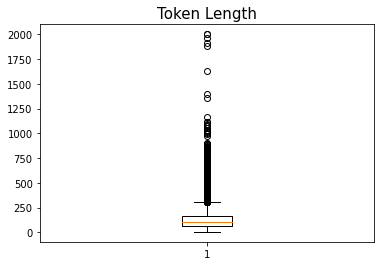

In [ ]:
plt.boxplot(tokens_len)
print('25%: ', np.quantile(tokens_len, q=0.25))
print('50%: ', np.quantile(tokens_len, q=0.5))
print('75%: ', np.quantile(tokens_len, q=0.75))
print('85%: ', np.quantile(tokens_len, q=0.85))
print('90%: ', np.quantile(tokens_len, q=0.9))
print('95%: ', np.quantile(tokens_len, q=0.95))
print('99%: ', np.quantile(tokens_len, q=0.99))
plt.title('Token Length', fontsize=15)
plt.show()

- 산점도

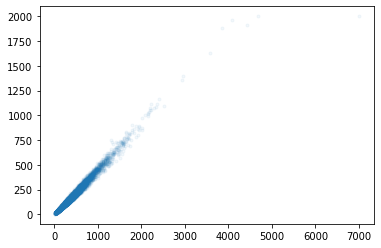

In [ ]:
plt.plot(texts_len, tokens_len, '.', alpha=0.05)

`-` $\text{토큰 길이} \times 2 \approx \text{텍스트 길이}$

### cut text 적용 O

In [ ]:
train_texts = df['overview'].values
train_texts = minor2major(train_texts, minor2major_dict)
train_texts = clean_texts(train_texts)
train_texts = major2minor(train_texts, major2minor_dict)
train_texts = cut_texts(train_texts, max_len=550)
train_texts = delete_duplicate_fullstops(train_texts)

- 텍스트 길이

In [ ]:
texts_len = list(map(len, train_texts))

25%:  151.0
50%:  249.0
75%:  374.0
85%:  454.0
90%:  494.0
95%:  523.0
99%:  544.0


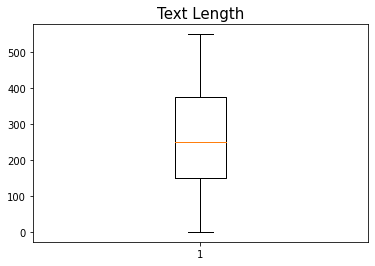

In [ ]:
plt.boxplot(texts_len)
print('25%: ', np.quantile(texts_len, q=0.25))
print('50%: ', np.quantile(texts_len, q=0.5))
print('75%: ', np.quantile(texts_len, q=0.75))
print('85%: ', np.quantile(texts_len, q=0.85))
print('90%: ', np.quantile(texts_len, q=0.9))
print('95%: ', np.quantile(texts_len, q=0.95))
print('99%: ', np.quantile(texts_len, q=0.99))
plt.title('Text Length', fontsize=15)
plt.show()

- 토큰 길이

In [ ]:
tokens_len = []
for text in tqdm(train_texts):
    inputs = tokenizer(
            text, 
            return_tensors='pt',
            truncation=True,
            max_length=2000,
            pad_to_max_length=True,
            add_special_tokens=True
        )
    inputs = torch.sum(inputs['attention_mask'])
    tokens_len.append(inputs)

  0%|          | 0/16986 [00:00<?, ?it/s]

25%:  65.0
50%:  106.0
75%:  161.0
85%:  196.0
90%:  216.5
95%:  237.0
99%:  261.0


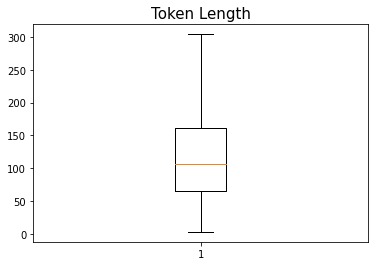

In [ ]:
plt.boxplot(tokens_len)
print('25%: ', np.quantile(tokens_len, q=0.25))
print('50%: ', np.quantile(tokens_len, q=0.5))
print('75%: ', np.quantile(tokens_len, q=0.75))
print('85%: ', np.quantile(tokens_len, q=0.85))
print('90%: ', np.quantile(tokens_len, q=0.9))
print('95%: ', np.quantile(tokens_len, q=0.95))
print('99%: ', np.quantile(tokens_len, q=0.99))
plt.title('Token Length', fontsize=15)
plt.show()

- 산점도

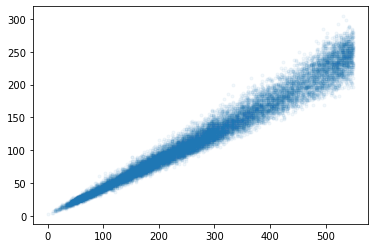

In [ ]:
plt.plot(texts_len, tokens_len, '.', alpha=0.05)

`-` $\text{토큰 길이} \times 2 \approx \text{텍스트 길이}$

## 텍스트 전처리

`-` 클래스별로 워드클라우드를 그려보자

`-` 공공기관 데이터라 그런지 글의 띄어쓰기, 맞춤법 상태가 나쁘지 않은 편이다

`-` html 태그 제거해야 함

`-` yyyy년 mm월 dd일, n층, $m^2$ 제거해야 함

`-` 숫자 단어 제거하면 안되는 경우: 5일장

`-` 개요가 8천글자......

`-` 굳이 설명을 다 읽을 필요가 있을까?

`-` 일반적으로 주요 내용을 앞에서 설명하고 뒤의 설명은 부가적이다

`-` 그러면 굳이 개요 전부를 읽지말고 중간 부근까지만 읽어보자

`-` 짧은 글은 전체를 다 읽고 긴 글은 다 읽지 말자

`-` 문장은 마침표를 기준으로 구분되어 있다

`-` cutting할 때는 마침표 위치를 찾고 원하는 지점에 가장 가까운 마침표를 기준으로 잘라내자

`-` **적은 클래스를 오버샘플링 해보자** 

`-` 내가 임의로 텍스트를 살짝 변경하면 될 듯

`-` 아니면 마침표를 기준으로 문장을 추출한 후 문장을 랜덤셔플하여 텍스트를 생성해보자

`-` 또한, 임의의 문장을 드랍할 수 도 있다 (단 2문장 이상일 때만)

`-` agumentation class를 만들자 (마침표를 기준으로 문장 추출, 랜덤 셔플, 드랍)

`-` 잘못 라벨링된 텍스트가 존재한다, 이를 찾아내는 함수를 만들고 수기 라벨링 해보자

#### 소수 클래스 개요 확인

`-` 몇개 확인해봤는데 맞추기 쉽거나 거의 못 맞추거나 둘 중 하나인 듯하다

In [ ]:
minor_classes = df['cat3'].value_counts()[-30:].reset_index()['index'].to_numpy()
minor_classes

array(['컨벤션센터', '식음료', '카약/카누', '학교', '헹글라이딩/패러글라이딩', '사격장', '분수', '터널',
       '스노쿨링/스킨스쿠버다이빙', '외국문화원', '카트', '면세점', '스키/스노보드', '전통공연', '클럽',
       '이색체험', '연극', '백화점', '번지점프', '영화관', '카지노', 'ATV', '빙벽등반', '발전소',
       '뮤지컬', 'MTB', '대중콘서트', '인라인(실내 인라인 포함)', '스카이다이빙', '클래식음악회'],
      dtype=object)

- 컨벤션센터

`-` 컨벤션이 있고 컨벤션센터가 있다 ㅋㅋㅋ

`-` 범주가 컨벤션센터인 텍스트는 11개이고 그 중 2개 텍스트에는 컨벤션센터라는 단어가 들어있지 않다

- 식음료

`-` 음식 + 관광지

`-` 주류(와인)이 많이 언급됨

- 클럽

`-` 음식점으로 분류됨......

#### 단어 대체

`-` 단어를 다른 단어로 대체할 필요가 있음

`-` 예컨대 cate -> 카페

`-` 까페 -> 카페

`-` ATV -> 오토바이

`-` 일정개수 이상 등장하는 영어단어에 `check_word_counts` 함수를 적용하자

In [ ]:
def check_word_counts(word: str, texts: Sequence[str], labels: NDArray[np.str_]) -> Dict[str, int]:
    count_dict = {}
    for idx, text in enumerate(texts):
        text = text.lower()
        label = labels[idx]
        if word in text:  ## text 대신 text.split()을 사용하면 더 타이트하게 검출
            if label not in count_dict:
                count_dict[label] = 1
            else:
                count_dict[label] += 1

    all_counts = sum([np.sum(labels == key) for key in list(count_dict.keys())])
    count_dict.update({'합계':sum(count_dict.values())})
    count_list = list(count_dict.items())
    count_list = list(map(list, count_list))

    for item in count_list:
        if item[0] == '합계':
            item.append(all_counts)
        else:
            item.append(np.sum(labels == item[0]))

    count_list = sorted(count_list, key=lambda item: (-item[1], -item[2]))
    return count_list

In [ ]:
def check_english_df(texts: Sequence[str]) -> Dict[str, int]:
    """영단어별 document frequency를 계산"""
    eng_dict = {}
    for text in texts:
        text = text.lower()
        words = text.split()
        duplicate = {}
        for word in words:
            if word.encode().isalpha() and word not in duplicate:
                if word not in eng_dict:
                    eng_dict[word] = 1
                else:
                    eng_dict[word] += 1
                duplicate[word] = True

    eng_dict.update({'고유한 영단어 개수':len(eng_dict)})
    eng_dict = sorted(eng_dict.items(), key=lambda item: item[1], reverse=True)
    return eng_dict

In [ ]:
# check_english_df(df['overview'].values)

In [ ]:
check_word_counts('bbq', df['overview'].values, df['cat3'].values)

[['합계', 49, 6802],
 ['한식', 34, 3438],
 ['야영장,오토캠핑장', 9, 1558],
 ['펜션', 2, 445],
 ['일반축제', 1, 549],
 ['이색거리', 1, 467],
 ['서양식', 1, 226],
 ['민물낚시', 1, 119]]

### 라벨링

`-` 라벨이 잘못 부여된 텍스트가 존재한다

`-` 데이터가 많이 존재하는 경우에는 괜찮을 수 있으나 데이터가 적은 경우 모델이 잘못 학습할 수 있다

`-` 모델의 일반화 성능 향상을 위해 제대로 라벨링 해주자

`-` 적은 데이터를 가진 클래스의 경우 일일이 확인할 수 있다

`-` 하지만 한식 클래스와 같이 데이터가 많은 경우 일일이 확인할 수 없다

- 어떻게 찾아낼 것인가?

`-` 같은 클래스에서 거의 사용되지 않은 단어가 사용됐다면 이상치일 가능성이 존재한다

In [ ]:
minor_classes

array(['컨벤션센터', '식음료', '카약/카누', '학교', '헹글라이딩/패러글라이딩', '사격장', '분수', '터널',
       '스노쿨링/스킨스쿠버다이빙', '외국문화원', '카트', '면세점', '스키/스노보드', '전통공연', '클럽',
       '이색체험', '연극', '백화점', '번지점프', '영화관', '카지노', 'ATV', '빙벽등반', '발전소',
       '뮤지컬', 'MTB', '대중콘서트', '인라인(실내 인라인 포함)', '스카이다이빙', '클래식음악회'],
      dtype=object)

In [ ]:
def get_overview(texts: NDArray[np.str_], label: str, labels: NDArray[np.str_]) -> Tuple[int, NDArray[np.str_]]:
    idx = [i for i, target in enumerate(labels) if target == label]
    return idx, texts[idx]

In [ ]:
normal = ['클래식음악회', 
          '스카이다이빙',
          '대중콘서트',
          'MTB',
          '뮤지컬',
          '발전소',
          '카지노',
          '영화관',
          '번지점프',
          '백화점',
          '이색체험',
          '전통공연',
          '스키/스노보드',
          '면세점',
          '카트',
          '외국문화원',
          '스노쿨링/스킨스쿠버다이빙',
          '분수',
          '사격장',
          '헹글라이딩/패러글라이딩',          
          ]

## abnormal은 이미지를 확인할 필요가 있다
abnormal = {'빙벽등반-5113':'체험시설',
            '빙벽등반-6992':'펜션 캠핑장, 글램핑',
            '빙벽등반-8552':'클라이밍',
            '빙벽등반-11338':'클라이밍',
            'ATV-4958':'공룡 전시관',
            '클럽-15876':'한식',
            '터널-1210':'공원',
            '학교-10715':'연구소',
            '카약/카누-7021':'학교',
            '식음료-10351':'이색체험',
            '기타-886':'박물관',
            '기타-4500':'전시관',
            }

## 모델 학습 방법

`1.` 이미지만으로 카테고리를 구분할 수 있다

`2.` 텍스트만으로 카테고리를 구분할 수 있다

`3.` 이미지와 텍스트로 카테고리를 구분할 수 있다

`-` 만약 방법 1 또는 2가 성립한다면 모델을 각각 만들고 앙상블을 통해 예측해도 된다

`-` 만약 오직 방법 3만 성립한다면 이미지와 텍스트를 같이 사용해 모델을 학습시켜야 한다 (예컨대 forward 에서 concat 하든지)

`-` 방법 1은 성립하지 않는 것 같다......

## 모델 학습 준비

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from torch.nn.modules.loss import _WeightedLoss
from torch.optim import Optimizer

import albumentations as A
from albumentations.core.transforms_interface import BasicTransform

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'현재 device는 {device}입니다')

현재 device는 cuda입니다


In [25]:
def seed_everything(seed: int = 22) -> None:
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [26]:
def clear_gpu() -> None:
    gc.collect()
    torch.cuda.empty_cache()

- 훈련 텍스트 불러오기

In [27]:
train_texts = df['overview'].values
train_texts = minor2major(train_texts, minor2major_dict)
train_texts = clean_texts(train_texts)
train_texts = major2minor(train_texts, major2minor_dict)
train_texts = delete_duplicate_fullstops(train_texts)
train_texts = cut_texts(train_texts, max_len=550)
train_texts = add_fullstop(train_texts)
train_texts = np.array(train_texts)

- 데이터 셋과 데이터 로더

In [28]:
class TextDataset(Dataset):
    def __init__(
        self, 
        tokenizer: AutoTokenizer,
        texts: Sequence[NDArray], 
        labels: Optional[Sequence[int]] = None,
        max_len: int = 512,
        transforms: Optional[Callable[[str], Dict[str, str]]] = None
    ) -> None:
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.transforms = transforms
    
    def __getitem__(self, idx: int) -> Union[Tuple[Tensor, Tensor, int], Tuple[Tensor, Tensor]]:
        text = self.texts[idx]
        if self.transforms is not None:
            text = self.transforms(text=text)['text']

        inputs = self.tokenizer(
            text, 
            return_tensors='pt',
            truncation=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            add_special_tokens=True
        )
        
        input_ids = inputs['input_ids'][0]
        attention_mask = inputs['attention_mask'][0]

        if self.labels is not None:
            label = self.labels[idx]
            return input_ids, attention_mask, label
        return input_ids, attention_mask  ## test는 라벨이 없다

    def __len__(self) -> int:
        return len(self.texts)

In [29]:
def get_text_dataloader(
        tokenizer: AutoTokenizer, 
        X: Sequence[NDArray],  
        y: Optional[Sequence[int]] = None,
        max_len: int = 512,
        transforms: Optional[Callable[[str], Dict[str, str]]] = None,
        shuffle_dataloader: bool = True,
        drop_last: bool = False
    ) -> DataLoader:
    dataset = TextDataset(tokenizer, X, y, max_len, transforms)    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=shuffle_dataloader, drop_last=drop_last)
    return dataloader

- 데이터 변환

`-` https://github.com/Jaesu26/text-augmentation

In [30]:
Word = str
Sentence = str
Text = str


def swap_words(words: List[Word], deepcopy: bool = False) -> List[Word]:
    """Randomly swap two words"""
    if len(words) < 2:
        return words
    
    if deepcopy:
        words = copy.deepcopy(words)
        
    idx1, idx2 = np.random.choice(len(words), size=2, replace=False)
    words[idx1], words[idx2] = words[idx2], words[idx1]
    return words


def swap_sentences(sentences: List[Sentence], ignore_first: bool, deepcopy: bool = False) -> List[Sentence]:
    """Randomly swap two sentences"""
    if len(sentences) < ignore_first + 2:
        return sentences
    
    if deepcopy:
        sentences = copy.deepcopy(sentences)
        
    idx1, idx2 = np.random.choice(np.arange(ignore_first, len(sentences)), size=2, replace=False)
    sentences[idx1], sentences[idx2] = sentences[idx2], sentences[idx1]
    return sentences


def delete_words(words: List[Word], min_words: int, deletion_prob: float) -> List[Word]:
    """Randomly delete words""" 
    if len(words) <= min_words:
        return words

    new_words = []
    deletion_max_counts = len(words) - min_words
    deletion_counts = 0
    
    for word in words:
        if np.random.random() < deletion_prob and deletion_counts < deletion_max_counts:
            deletion_counts += 1
            continue
            
        new_words.append(word)
    return new_words


def delete_sentences(
    sentences: List[Sentence], 
    min_sentences: int, 
    deletion_prob: float, 
    ignore_first: bool
) -> List[Sentence]:
    """Randomly delete sentences"""
    if len(sentences) <= min_sentences:
        return sentences

    new_sentences = [sentences[0]] if ignore_first else [] 
    deletion_max_counts = len(sentences) - min_sentences
    deletion_counts = 0
    
    for sentence in sentences[ignore_first:]:
        if np.random.random() < deletion_prob and deletion_counts < deletion_max_counts:
            deletion_counts += 1
            continue

        new_sentences.append(sentence)
    return new_sentences


def delete_fullstops(text: Text) -> Text:
    """Delete full stops in the text"""
    text = text.replace(".", " ")
    text = re.sub(r"\s+", " ", text) 
    text = text.strip()   
    return text

In [31]:
class TextTransform(BasicTransform):
    """Transform applied to a text"""

    @property
    def targets(self) -> Dict[str, Callable[[Text], Text]]:
        return {"text": self.apply}
      
    def update_params(self, params: Dict[str, Any], **kwargs: Any) -> Dict[str, Any]:
        return params 

    def get_words_from_sentence(self, sentence: Sentence) -> List[Word]:
        """Split the sentence to get words"""
        words = list(map(lambda word: word.strip(), sentence.split()))
        return words
    
    def get_sentences_from_text(self, text: Text) -> List[Sentence]:
        """Split the text to get sentences"""
        sentences = list(map(lambda sentence: sentence.strip(), text.split(".")))
        if text.endswith("."):
            return sentences[:-1]
        return sentences 
    
    def get_sentence_from_words(self, words: List[Word]) -> Sentence:
        """Combine words to get a sentence"""
        sentence = " ".join(words)
        return sentence
    
    def get_text_from_sentences(self, sentences: List[Sentence]) -> Text:
        """Combine sentences to get a text"""
        text = ". ".join(sentences)
        text = text + "." if text else ''
        return text

    
class RandomSwapWords(TextTransform):
    """Randomly swap two words in a random sentence"""

    def __init__(
        self, 
        ignore_first: bool = False,
        always_apply: bool = False, 
        p: float = 0.5
    ) -> None:
        super(RandomSwapWords, self).__init__(always_apply, p)
        self.ignore_first = ignore_first

    def apply(self, text: Text, **params: Any) -> Text:
        sentences = self.get_sentences_from_text(text)
        if len(sentences) <= self.ignore_first:
            return text

        idx = np.random.randint(self.ignore_first, len(sentences))
        words = self.get_words_from_sentence(sentences[idx])
        words = swap_words(words)
        sentence = self.get_sentence_from_words(words)
        sentences[idx] = sentence
        text = self.get_text_from_sentences(sentences)
        return text

    def get_transform_init_args_names(self) -> Tuple[str]:
        return ("ignore_first",)

    
class RandomSwapSentences(TextTransform):
    """Randomly swap two sentences in the text"""

    def __init__(
        self, 
        ignore_first: bool = False,
        always_apply: bool = False, 
        p: float = 0.5
    ) -> None:
        super(RandomSwapSentences, self).__init__(always_apply, p)
        self.ignore_first = ignore_first

    def apply(self, text: Text, **params: Any) -> Text:
        sentences = self.get_sentences_from_text(text)
        sentences = swap_sentences(sentences, self.ignore_first)
        text = self.get_text_from_sentences(sentences)
        return text

    def get_transform_init_args_names(self) -> Tuple[str]:
        return ("ignore_first",)


class RandomDeletionWords(TextTransform):
    """Randomly delete words in the text"""

    def __init__(
        self, 
        min_words_each_sentence: int = 5,
        deletion_prob: float = 0.1, 
        ignore_first: bool = False,
        always_apply: bool = False, 
        p: float = 0.5
    ) -> None:
        super(RandomDeletionWords, self).__init__(always_apply, p)
        
        if not isinstance(min_words_each_sentence, int) or min_words_each_sentence < 0:
            raise ValueError(f"min_words_each_sentence must be non negative integer. Got: {min_words_each_sentence}")
        
        self.min_words_each_sentence = min_words_each_sentence
        self.deletion_prob = deletion_prob
        self.ignore_first = ignore_first

    def apply(self, text: Text, **params: Any) -> Text:
        sentences = self.get_sentences_from_text(text)
        new_sentences = [sentences[0]] if self.ignore_first else [] 
        
        for sentence in sentences[self.ignore_first:]:
            words = self.get_words_from_sentence(sentence)
            words = delete_words(words, self.min_words_each_sentence, self.deletion_prob)
            new_sentence = self.get_sentence_from_words(words)
            if new_sentence:
                new_sentences.append(new_sentence)

        text = self.get_text_from_sentences(new_sentences)
        return text

    def get_transform_init_args_names(self) -> Tuple[str, str, str]:
        return ("min_words_each_sentence", "deletion_prob", "ignore_first")


class RandomDeletionSentences(TextTransform):
    """Randomly delete sentences in the text"""

    def __init__(
        self, 
        min_sentences: int = 3,
        deletion_prob: float = 0.1,
        ignore_first: bool = False,
        always_apply: bool = False, 
        p: float = 0.5
    ) -> None:
        super(RandomDeletionSentences, self).__init__(always_apply, p)
        
        if not isinstance(min_sentences, int) or min_sentences < 0:
            raise ValueError(f"min_sentences must be non negative integer. Got: {min_sentences}")
    
        self.min_sentences = min_sentences
        self.deletion_prob = deletion_prob
        self.ignore_first = ignore_first

    def apply(self, text: Text, **params: Any) -> Text:
        sentences = self.get_sentences_from_text(text)
        sentences = delete_sentences(sentences, self.min_sentences, self.deletion_prob, self.ignore_first)
        text = self.get_text_from_sentences(sentences)
        return text

    def get_transform_init_args_names(self) -> Tuple[str, str, str]:
        return ("min_sentences", "deletion_prob", "ignore_first")

    
class DeletionFullstops(TextTransform):
    """Delete full stops in the text"""

    def __init__(self, always_apply: bool = False, p: float = 1.0) -> None:
        super(DeletionFullstops, self).__init__(always_apply, p)

    def apply(self, text: Text, **params: Any) -> Text:
        text = delete_fullstops(text)
        return text

    def get_transform_init_args_names(self) -> Tuple[()]:
        return ()

In [41]:
## 데이터 변환 방식을 정의 (Agumentation)
def get_transforms(phase: str) -> A.Compose:
    if phase == 'train':
        transforms = A.Compose([
            # RandomSwapSentences(p=0.5),
            # RandomSwapWords(p=0.5),
            RandomDeletionSentences(min_sentences=3, deletion_prob=0.1, p=0.5),
            # RandomDeletionWords(min_words_each_sentence=5, deletion_prob=0.1, p=0.5),
            # DeletionFullstops()  ## 마침표는 냅두는게 좋나? 문장을 구분할 수 있으니까?
        ])
    elif phase == 'valid':
        # transforms = A.Compose([DeletionFullstops()])
        transforms = None
    return transforms  ## 데이터 변환 방식을 반환

- 조기 중단

In [33]:
## Copyright (c) 2018 Bjarte Mehus Sunde
## ref: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """주어진 patience 횟수 이후로 validation score가 개선되지 않으면 학습을 조기 중단"""
    mode_dict = {'min':-1, 'max':1}
    score_metrics = [
        'accuracy',
        'f1_score',
    ]

    def __init__(
        self, 
        patience: int = 7, 
        monitor: str = 'loss', 
        mode: str = 'min', 
        min_delta: float = 0.0, 
        path: str = './weight', 
        model_name: str = '', 
        current_fold: int = 1
    ) -> None:
        """
        Args:
            patience (int): score가 개선될 때까지 기다리는 에폭
                            Default: 7
                          
            monitor (str): 값의 변화를 모니터링할 수치(score)
                            Default: 'loss'

            mode (str): score를 개선시킬 방식
                            Default: 'min'

            min_delta (float): 개선되었다고 인정되는 score의 최소 변화
                            Default: 0.0

            path (str): checkpoint 공통 저장 경로
                            Default: './weight'

            model_name (str): 학습시킬 모델의 이름
                            Default: ''

            current_fold (int): 현재 학습을 진행하는 fold의 순서
                            Default: 1
        """
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.direction = self.mode_dict[mode]
        self.monitor = monitor
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None  ## 평가지표 (i.g. accuracy)
        self.early_stop = False
        self.min_delta = min_delta
        self.path = path
        self.model_name = model_name
        self.current_fold = current_fold

    def __call__(
        self, 
        model: nn.Module, 
        valid_loss: float, 
        valid_metric_score: Optional[float] = None
    ) -> None:
        ## score는 클수록 좋다
        if self.monitor == 'loss':
            score = valid_loss * self.direction
        elif self.monitor in self.score_metrics:
            score = valid_metric_score * self.direction
        else:
            score = None

        ## score가 개선되었는지 확인
        if score <= self.best_score + self.min_delta: 
            self.counter += 1 
            if self.counter > self.patience:  ## 만약 score가 개선되지 않은 에폭이 patience 횟수보다 크다면 조기 중단
                self.early_stop = True
        else: 
            self.best_score = score 
            self.save_checkpoint(model, valid_loss, valid_metric_score) 
            self.counter = 0  ## score가 개선되었으므로 0으로 변경

    def save_checkpoint(
        self, 
        model: nn.Module, 
        valid_loss: float, 
        valid_metric_score: Optional[float] = None
    ) -> None:
        """validation score가 개선되면 모델을 저장"""
        torch.save(model.state_dict(), self.path + f'/{self.model_name}_best_{self.current_fold}.pt') 
        self.valid_loss = valid_loss  ## 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.valid_metric_score = valid_metric_score  ## 이때의 valid metric score도 변경해준다

    def check_early_stop(self) -> bool:
        return self.early_stop

    def set_fold(self, current_fold: int) -> None:
        self.current_fold = current_fold

    def reset_score(self) -> None:
        """다음 fold 학습을 위해 score 관련 파라미터를 초기화"""
        self.counter = 0
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None
        self.early_stop = False

## 모델 K겹 교차검증

- Kfold와 손실 함수

In [34]:
## https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/25
class FocalLoss(_WeightedLoss):
    def __init__(
        self,
        alpha: float = 0.25,
        gamma: float = 2.0,
        weight: Optional[Tensor] = None,
        label_smoothing: float = 0.0,
        reduction: str = 'mean'
    ) -> None:
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        ce_loss = F.cross_entropy(
            input,
            target,
            weight=self.weight,
            label_smoothing=self.label_smoothing,
            reduction='none'
        )
        p_t = torch.exp(-ce_loss)
        loss = self.alpha * ce_loss * (1 - p_t)**self.gamma

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()
        return loss

In [35]:
skfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
loss_fn = FocalLoss(alpha=0.25, gamma=2.5, label_smoothing=LABEL_SMOOTHING)

- early stopping

In [42]:
early_stopping = EarlyStopping(patience=7,
                               monitor='f1_score',
                               mode='max',
                               path=SAVE_PATH,
                               model_name=MODEL_TYPE,
                               current_fold=1)  ## patience 횟수 에폭 후에도 검증 손실이 작아지지 않으면 조기 중단

- 이미지 

`-` 손절

- 텍스트

In [43]:
def train(
        model: nn.Module,
        dataloader: DataLoader, 
        optimizer: Optimizer, 
        loss_fn: _WeightedLoss, 
        scheduler: Optional[_LRScheduler] = None,
        use_amp: bool = False
    ) -> Tuple[nn.Module, float]:
    """dataloader의 데이터로 모델을 학습시킨 후 학습된 모델과 평균 배치 훈련 오차를 반환"""  
    train_loss = 0.0  ## mini-batch 평균 훈련 오차 
    model = model.to(device)
    model.train()
    if use_amp:
        scaler = torch.cuda.amp.GradScaler()

    for input_ids, attention_masks, y in tqdm(dataloader):  ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        y = y.to(device)
        optimizer.zero_grad()  ## 그래디언트 초기화
        
        if use_amp:
            with torch.cuda.amp.autocast():
                y_hat = model(input_ids, attention_masks)[0]
                loss = loss_fn(y_hat, y)  
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            y_hat = model(input_ids, attention_masks)[0]
            loss = loss_fn(y_hat, y)  
            loss.backward()   ## 미분
            optimizer.step()  ## 업데이트
        train_loss += (loss.item() / len(dataloader)) 
  
        ## 배치마다 학습률 조절
        if scheduler is not None:
            scheduler.step()
        
    return model, train_loss

In [44]:
def evaluate(
        model: nn.Module, 
        dataloader: DataLoader, 
        loss_fn: _WeightedLoss,
        use_amp: bool = False
    ) -> Tuple[float, float, float]:
    """dataloader의 데이터를 모델이 평가한 후 평균 배치 검증 오차와 accuracy, f1 score를 반환"""
    valid_loss, valid_acc, valid_f1 = 0.0, 0.0, 0.0  ## mini-batch 평균 검증 오차와 accuracy, f1 score
    y_list, yhat_list = [], []
    model = model.to(device)
    model.eval()  

    with torch.no_grad():  ## 역전파를 계산할 필요가 없으니까
        for input_ids, attention_masks, y in dataloader:  ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
            input_ids = input_ids.to(device)
            attention_masks = attention_masks.to(device)
            y = y.to(device)
            if use_amp:
                with torch.cuda.amp.autocast():
                    y_hat = model(input_ids, attention_masks)[0]
                    loss = loss_fn(y_hat, y)  
            else:
                y_hat = model(input_ids, attention_masks)[0]
                loss = loss_fn(y_hat, y)  

            y_list.extend(y.detach().cpu().numpy().tolist())
            yhat_list.extend(y_hat.argmax(-1).detach().cpu().numpy().tolist())
            valid_loss += loss.item() / len(dataloader)
            
    valid_acc = accuracy_score(y_list, yhat_list)
    valid_f1 = f1_score(y_list, yhat_list, average='weighted')
    return valid_loss, valid_acc, valid_f1

In [45]:
def kfold_cross_validate(
        model: nn.Module, 
        X: NDArray[np.str_], 
        y: NDArray[np.int_], 
        tokenizer: AutoTokenizer,
        skfold: StratifiedKFold, 
        loss_fn: _WeightedLoss, 
        early_stopping: EarlyStopping,
        use_amp: bool = False
    ) -> Tuple[nn.Module, List[List[float]], List[List[float]]]:
    """K겹 교차검증을 통해 모델의 성능을 평가하고 학습된 모델과 폴드별 훈련 손실, 폴드별 검증 손실을 반환"""
    seed_everything(SEED)  ## 정확한 재현을 위함
    num_folds = skfold.n_splits  ## 폴드의 개수
    fold_valid_loss = []  ## 폴드별 가장 작은 검증 손실
    fold_valid_f1 = []  ## 폴드별 가장 작은 검증 손실을 가질 때의 f1 score
    fold_train_losses_per_epoch = [[] for _ in range(num_folds)]  ## 폴드별 1 에폭에 따른 훈련 배치 손실
    fold_valid_losses_per_epoch = [[] for _ in range(num_folds)]  ## 폴드별 1 에폭에 따른 검증 배치 손실

    for fold, (train_idx, valid_idx) in enumerate(skfold.split(X, y)):
        print(f'[{fold + 1} / {num_folds}] Fold Training......')

        if fold != 0:
            continue

        ## 메모리 절약
        clear_gpu()
        
        ## 훈련 데이터와 검증 데이터로 분할
        X_train, X_valid = X[train_idx], X[valid_idx] 
        y_train, y_valid = y[train_idx], y[valid_idx]

        ## Dataloader
        train_dataloader = get_text_dataloader(tokenizer, X_train, y_train, MAX_LEN, get_transforms('train'), drop_last=True)
        valid_dataloader = get_text_dataloader(tokenizer, X_valid, y_valid, MAX_LEN)

        ## 딥러닝 모델의 기본 가중치 불러오기
        model.load_state_dict(torch.load(MODEL_DEFAULT_WEIGHT_PATH, map_location=device))

        ## optimizer
        optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)  

        ## scheduler
        t_total = len(train_dataloader) * NUM_EPOCHS  ## The total number of training steps
        warmup_step = t_total // 10  ## The number of steps for the warmup phase
        # scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)
        scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

        ## early stop, 다음 폴드 학습을 위해 score 관련 파라미터 초기화
        early_stopping.reset_score()
        early_stopping.set_fold(fold + 1)  
        
        ## 폴드마다 모델 학습
        for epoch in tqdm(range(1, NUM_EPOCHS+1)): ## (배치사이즈 X 에폭) 만큼 훈련시킴           
            model, train_loss = train(model, train_dataloader, optimizer, loss_fn, scheduler, use_amp)  ## 모델 학습
            valid_loss, valid_acc, valid_f1 = evaluate(model, valid_dataloader, loss_fn, use_amp)  ## 모델 평가
            fold_train_losses_per_epoch[fold].append(train_loss) 
            fold_valid_losses_per_epoch[fold].append(valid_loss)  

            print_score_condition = (epoch == 1 or epoch % 1 == 0 or epoch == NUM_EPOCHS)  
            score_information = f'[Epoch: {epoch:>2}]  train loss = {train_loss:.5f}  valid loss = {valid_loss:.5f}  valid acc = {valid_acc:.5f}  valid f1 = {valid_f1:.5f}'

            ## 평균 배치 훈련 오차와 검증 오차 출력
            if print_score_condition:  
                print(score_information)  
                
            ## 에폭마다 early stopping 실행
            early_stopping(model, valid_loss, valid_f1)  ## __call__ function
            if early_stopping.check_early_stop(): 
                if not print_score_condition:  ## 이미 출력한 에폭에 대해 중복으로 출력하지 않기 위함
                    print(score_information) 
                print('Early Stopping!')
                break 

        fold_valid_loss.append(early_stopping.valid_loss)  ## 폴드별 가장 작은 검증 손실
        fold_valid_f1.append(early_stopping.valid_metric_score)  ## 폴드별 가장 작은 검증 손실일 때의 정확도
         
        ## 폴드별 학습 및 검증 종료시 가장 작은 검증 손실과 이때의 f1 score를 출력
        print(f'{fold + 1} Fold -> Best Valid Loss: {early_stopping.valid_loss:.5f} Valid F1 score: {early_stopping.valid_metric_score:.5f}', end='\n\n')
        
    ## 폴드별 가장 손실이 작은 모델의 평균 검증 손실과 이때의 평균 정확도를 출력
    print(f'{num_folds} Fold Mean Valid Best Loss: {np.mean(fold_valid_loss):.5f}')
    print(f'{num_folds} Fold Mean Valid F1 score: {np.mean(fold_valid_f1):.5f}')
    return model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch

- 모델 선언 및 가중치 저장

In [46]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME[MODEL_TYPE], num_labels=NUM_CLASSES)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME[MODEL_TYPE])  
# torch.save(model.state_dict(), MODEL_DEFAULT_WEIGHT_PATH) 

Downloading:   0%|          | 0.00/620 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/473M [00:00<?, ?B/s]

Some weights of the model checkpoint at kykim/electra-kor-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at kykim/electra-kor-base and are newly initialized: ['classifier.out_proj.weight', 'clas

Downloading:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/344k [00:00<?, ?B/s]

- 모델 K겹 교차검증

`-` 23시 20분 시작

In [47]:
model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch = kfold_cross_validate(model, train_texts, target, tokenizer, skfold, loss_fn, early_stopping, use_amp=True)

[1 / 5] Fold Training......


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 1.07344  valid loss = 0.84851  valid acc = 0.31725  valid f1 = 0.17365


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch:  2]  train loss = 0.68018  valid loss = 0.51195  valid acc = 0.55974  valid f1 = 0.47005


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch:  3]  train loss = 0.42951  valid loss = 0.36399  valid acc = 0.67893  valid f1 = 0.62106


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch:  4]  train loss = 0.30913  valid loss = 0.30103  valid acc = 0.73337  valid f1 = 0.69316


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch:  5]  train loss = 0.23960  valid loss = 0.28252  valid acc = 0.75898  valid f1 = 0.72829


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch:  6]  train loss = 0.20078  valid loss = 0.25514  valid acc = 0.77781  valid f1 = 0.75726


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch:  7]  train loss = 0.16945  valid loss = 0.25204  valid acc = 0.78693  valid f1 = 0.76973


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch:  8]  train loss = 0.14669  valid loss = 0.25060  valid acc = 0.80606  valid f1 = 0.79472


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch:  9]  train loss = 0.12691  valid loss = 0.25628  valid acc = 0.80636  valid f1 = 0.79809


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch: 10]  train loss = 0.11316  valid loss = 0.26370  valid acc = 0.80165  valid f1 = 0.79754


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch: 11]  train loss = 0.10265  valid loss = 0.26896  valid acc = 0.79988  valid f1 = 0.79351


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch: 12]  train loss = 0.09311  valid loss = 0.25561  valid acc = 0.81254  valid f1 = 0.80544


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch: 13]  train loss = 0.08831  valid loss = 0.25768  valid acc = 0.81401  valid f1 = 0.80789


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch: 14]  train loss = 0.08270  valid loss = 0.26016  valid acc = 0.80753  valid f1 = 0.80375


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch: 15]  train loss = 0.07752  valid loss = 0.25954  valid acc = 0.81165  valid f1 = 0.80672


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch: 16]  train loss = 0.07388  valid loss = 0.25727  valid acc = 0.81813  valid f1 = 0.81456


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch: 17]  train loss = 0.06879  valid loss = 0.27527  valid acc = 0.81519  valid f1 = 0.81418


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch: 18]  train loss = 0.06762  valid loss = 0.26388  valid acc = 0.81607  valid f1 = 0.81203


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch: 19]  train loss = 0.06529  valid loss = 0.25158  valid acc = 0.82372  valid f1 = 0.82047


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch: 20]  train loss = 0.06465  valid loss = 0.25791  valid acc = 0.81989  valid f1 = 0.81904


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch: 21]  train loss = 0.06183  valid loss = 0.25847  valid acc = 0.82490  valid f1 = 0.82253


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch: 22]  train loss = 0.06041  valid loss = 0.25685  valid acc = 0.82490  valid f1 = 0.82120


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch: 23]  train loss = 0.05958  valid loss = 0.25571  valid acc = 0.82725  valid f1 = 0.82585


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch: 24]  train loss = 0.05899  valid loss = 0.26016  valid acc = 0.82490  valid f1 = 0.82300


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch: 25]  train loss = 0.05783  valid loss = 0.26268  valid acc = 0.82666  valid f1 = 0.82296


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch: 26]  train loss = 0.05800  valid loss = 0.25855  valid acc = 0.82755  valid f1 = 0.82467


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch: 27]  train loss = 0.05725  valid loss = 0.25912  valid acc = 0.82490  valid f1 = 0.82290


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch: 28]  train loss = 0.05659  valid loss = 0.25459  valid acc = 0.82725  valid f1 = 0.82463


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch: 29]  train loss = 0.05644  valid loss = 0.26158  valid acc = 0.82725  valid f1 = 0.82449


  0%|          | 0/212 [00:00<?, ?it/s]

[Epoch: 30]  train loss = 0.05677  valid loss = 0.25441  valid acc = 0.82755  valid f1 = 0.82497
1 Fold -> Best Valid Loss: 0.25571 Valid F1 score: 0.82585

[2 / 5] Fold Training......
[3 / 5] Fold Training......
[4 / 5] Fold Training......
[5 / 5] Fold Training......
5 Fold Mean Valid Best Loss: 0.25571
5 Fold Mean Valid F1 score: 0.82585


1234567891011

- train loss와 valid loss의 변화를 시각화

In [48]:
def show_loss_plot(
        fold_train_losses: List[List[float]],
        fold_valid_losses: List[List[float]]
    ) -> None:
    """폴드별로 에폭에 따른 모델의 훈련 손실과 검증 손실의 변화를 시각화"""
    assert len(fold_train_losses) == len(fold_valid_losses)
    num_folds = len(fold_train_losses)
    ncols = 3
    nrows = 1 + (num_folds - 1)//ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4)) 

    ## 폴드마다 에폭에 따른 훈련 손실과 검증 손실의 변화를 시각화
    for fold, (ax, train_losses, valid_losses) in enumerate(zip(axes.flatten(), fold_train_losses, fold_valid_losses), start=1):
        assert len(train_losses) == len(valid_losses) 
        if fold > num_folds:
            break

        num_epochs = len(train_losses)
        ax.set_title(f'{fold} Fold')
        ax.plot(range(1, num_epochs+1), train_losses, label='Train')
        ax.plot(range(1, num_epochs+1), valid_losses, label='Valid')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()

    fig.suptitle('Train Loss and Valid Loss', x=0.51, y=1.05, fontsize=15)
    fig.tight_layout()

    ## 남는 서브 플랏 제거
    for ax in axes.flatten():
        if not ax.has_data():
            fig.delaxes(ax)

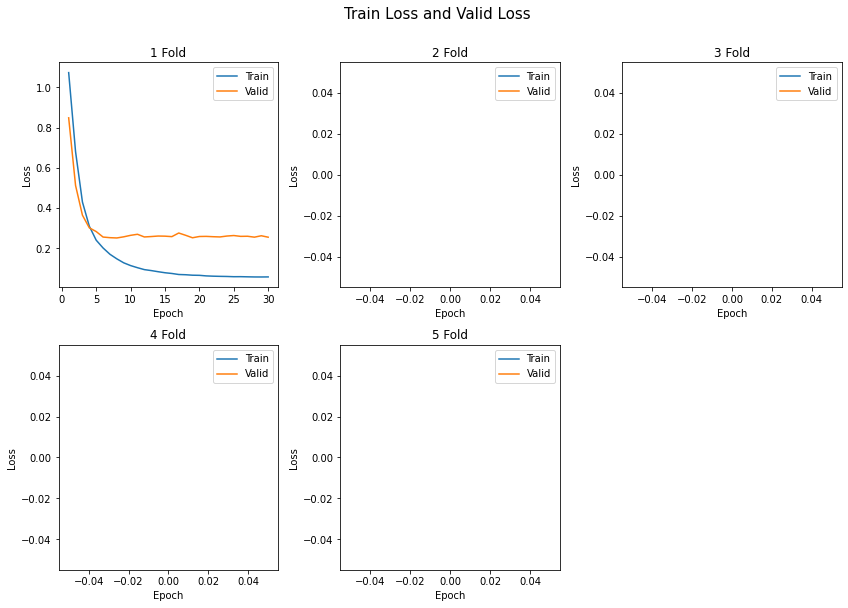

In [49]:
show_loss_plot(fold_train_losses_per_epoch, fold_valid_losses_per_epoch)

## Test 예측

In [50]:
test_texts = test['overview'].values
test_texts = minor2major(test_texts, minor2major_dict)
test_texts = clean_texts(test_texts)
test_texts = major2minor(test_texts, major2minor_dict)
test_texts = delete_duplicate_fullstops(test_texts)
test_texts = cut_texts(test_texts, max_len=550)
test_texts = add_fullstop(test_texts)
test_texts = np.array(test_texts)

In [51]:
def get_first_sentences(texts: Sequence[str]) -> List[str]:
    return [text.split('.')[0].strip() for text in texts]

In [52]:
def predict(
        model: nn.Module, 
        dataloader: DataLoader, 
        weight_save_path: str, 
        return_prob: bool = False
    ) -> Tensor:
    """저장된 모델의 가중치를 불러와서 dataloader의 데이터를 예측하여 반환"""
    model = model.to(device) 
    weight_path_list = glob(weight_save_path + '/*.pt')
    test_probs = np.zeros(shape=(len(dataloader.dataset), NUM_CLASSES))  

    for weight_path in tqdm(weight_path_list):
        probs = None
        model.load_state_dict(torch.load(weight_path, map_location=device))
        model.eval()
        
        with torch.no_grad(): 
            for input_ids, attention_masks in dataloader:  ## test 데이터는 라벨(y)이 없다
                input_ids = input_ids.to(device) 
                attention_masks = attention_masks.to(device) 
                y_hat = model(input_ids, attention_masks)[0].detach().cpu().numpy()

                if probs is None:
                    probs = y_hat
                else:
                    probs = np.concatenate([probs, y_hat])

        test_probs += (probs / NUM_FOLDS) 
    test_probs = torch.softmax(torch.from_numpy(test_probs), dim=-1)  ## 각 컬럼별 확률
    _, test_preds = torch.max(test_probs, dim=-1)  ## 최댓값과 인덱스

    if return_prob:
        return test_probs  ## 각 컬럼별 확률
    return test_preds  ## 라벨

In [53]:
test_dataloader = get_text_dataloader(tokenizer=tokenizer, X=test_texts, y=None, max_len=MAX_LEN, transforms=None, shuffle_dataloader=False)

In [54]:
preds = predict(model, test_dataloader, SAVE_PATH, return_prob=False)

  0%|          | 0/1 [00:00<?, ?it/s]

In [55]:
submission['cat3'] = le.inverse_transform(preds)
submission.head()

,id,cat3
0,TEST_00000,한식
1,TEST_00001,한식
2,TEST_00002,한식
3,TEST_00003,수련시설
4,TEST_00004,자연생태관광지


In [58]:
# submission.to_csv(f'submission-{MODEL_TYPE}-addfullstop+deletesentences.csv', index=False)

In [56]:
test_texts[4]

'팔공산은 경산시의 북쪽에 위치한 해발 . 의 높은 산으로 신라시대에는 중악 부악으로 알려진 명산이다. 이곳에는 관봉석조여래좌상 갓바위 원효사 천성사 불굴사 등 신라 고찰과 문화유적이 많다. 전체면적 . 공원구역 . 공원보호구역.'

In [57]:
test['overview'].values[4]

'팔공산은 경산시의 북쪽에 위치한 해발 1192.3 m의 높은 산으로 신라시대에는 중악, 부악으로 알려진 명산이다. 이곳에는 관봉석조여래좌상(갓바위), 원효사, 천성사, 불굴사 등 신라 고찰과 문화유적이 많다.\n* 전체면적 - 95.687㎢(9,569ha)\n* 공원구역 - 91.487㎢(9,149ha)\n* 공원보호구역 - 4.2㎢(420ha)'

In [59]:
re.sub(r'\w*\d\w*', '', test['overview'].values[4]) 

'팔공산은 경산시의 북쪽에 위치한 해발 . m의 높은 산으로 신라시대에는 중악, 부악으로 알려진 명산이다. 이곳에는 관봉석조여래좌상(갓바위), 원효사, 천성사, 불굴사 등 신라 고찰과 문화유적이 많다.\n* 전체면적 - .㎢(,)\n* 공원구역 - .㎢(,)\n* 공원보호구역 - .㎢()'

In [73]:
re.sub(r'[^ ]*\d[^ ]*', '', test['overview'].values[4]) 

'팔공산은 경산시의 북쪽에 위치한 해발  m의 높은 산으로 신라시대에는 중악, 부악으로 알려진 명산이다. 이곳에는 관봉석조여래좌상(갓바위), 원효사, 천성사, 불굴사 등 신라 고찰과 문화유적이 많다.\n* 전체면적 -  공원구역 -  공원보호구역 - '